# Analysis 1 
- Outcome: ugica 
- Model: Individual CoxPH models for each subtype 
- Feature selection: Significant variables based on univariate analysis
- Predicts 5 year risk for combined UGI cancer outcome based on additive risk from subtype-specific models 
- Risk score threshold determined on 1) optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path
import json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0.csv")

In [8]:
json_filename = './../notebook/thresholds.json'
model = 'coxph'
subtypes = ['escc', 'eac', 'ncgc', 'cgc']
ro.globalenv['subtypes'] = list(subtypes)

In [9]:
# Load the JSON file
with open(json_filename, "r") as f:
    model_variables = json.load(f)

## Import each subtype-specific model and the variables for each model

In [10]:
selected_vars = set()
for subtype in subtypes:
    model_vars = set(model_variables[model][subtype]['variables'])
    selected_vars.update(model_vars)

ro.globalenv['selected_vars'] = list(selected_vars)
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean'] # Needed to factorize categorical vars later

In [11]:
for subtype in subtypes: 
    cox_model_name = f'coxph_{subtype}.rds'
    ro.globalenv[f'coxph_{subtype}'] = cox_model_name

In [12]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening"
)

subtype_outcomes <- c('ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC')

## Factorize categorical vars and set reference levels

In [13]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

## Helper functions
TODO: move to notebook utils file

In [14]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(subtype_outcomes), all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  return(risk)
}

# Gets actual event 
count_event <- function(validation_set, outcome, horizon_months = 60) {
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set[[outcome]] == 1)
  return(event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine




## Partition data

In [15]:
%%R 
selected_vars <- unlist(selected_vars) # Convert from list to a character vector 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set


[1] "Dataset Controls 16569" "Dataset Cases 164"     
[1] "Training Controls 13257" "Training Cases 130"     
[1] "Validation Controls 3312" "Validation Cases 34"     



## Results

### Estimate risk for each subtype and add to get combined ugica risk

In [16]:
%%R 
risk_columns <- list()

for (subtype in subtypes) {
    # Load cox model for that subtype 
    cox_model_name <- paste0('coxph_', subtype, '.RDS')
    cox_model <- readRDS(cox_model_name)

    # Predict risk of that subtype
    risk_5_years <- calculate_risk(cox_model, validation_set)

    # # Save risk column
    risk_col_name <- paste0('risk_5yr_', subtype)
    risk_columns[[risk_col_name]] <- risk_5_years
}

r_df_risk_subtypes <- data.frame(risk_columns)
r_df_risk_subtypes$risk_5yr_cum <- rowSums(r_df_risk_subtypes)
head(r_df_risk_subtypes)

   risk_5yr_escc risk_5yr_eac risk_5yr_ncgc risk_5yr_cgc risk_5yr_cum
8   0.0021063384 0.0014962316   0.008447973 0.0007232229  0.012773766
12  0.0006115359 0.0006841172   0.001440790 0.0003561957  0.003092639
24  0.0008852679 0.0005310277   0.002168734 0.0003426159  0.003927645
28  0.0062539375 0.0005727805   0.003176834 0.0007629085  0.010766461
29  0.0007558317 0.0009075600   0.002021781 0.0012616508  0.004946824
34  0.0281195073 0.0073257610   0.003485138 0.0024146480  0.041345054


In [17]:
%%R 
r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event_ugica = validation_set$ugica,
    event_escc = validation_set$ugica_ESCC,
    event_eac = validation_set$ugica_EAC,
    event_cgc = validation_set$ugica_CGC,
    event_ncgc = validation_set$ugica_NCGC,

    pred_risk_cum = r_df_risk_subtypes$risk_5yr_cum,
    pred_risk_escc = r_df_risk_subtypes$risk_5yr_escc,
    pred_risk_eac = r_df_risk_subtypes$risk_5yr_eac,
    pred_risk_cgc = r_df_risk_subtypes$risk_5yr_cgc,
    pred_risk_ncgc = r_df_risk_subtypes$risk_5yr_ncgc,
    
    ugica_5yr = count_event(validation_set, "ugica"),
    escc_5yr = count_event(validation_set, "ugica_ESCC"),
    eac_5yr = count_event(validation_set, "ugica_EAC"),
    cgc_5yr = count_event(validation_set, "ugica_CGC"),
    ncgc_5yr = count_event(validation_set, "ugica_NCGC")
)

risk_5_years <- r_df_validation_risk$pred_risk_cum
event_5_years <- r_df_validation_risk$ugica_5yr

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.725 
Sensitivity: 0.65 
Specificity: 0.7020445 
PPV: 0.01294821 
NPV: 0.9970111 
NNS: 100.4086 
     predicted_class
event    0    1
    0 2335  991
    1    7   13


### Sensitivity and Metrics at threshold that maximizes Youdens

In [18]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.725 
Sensitivity: 0.65 
Specificity: 0.7411305 
PPV: 0.01487414 
NPV: 0.9971683 
NNS: 83.03974 
     predicted_class
event    0    1
    0 2465  861
    1    7   13


### AUROC curves and PR curve

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



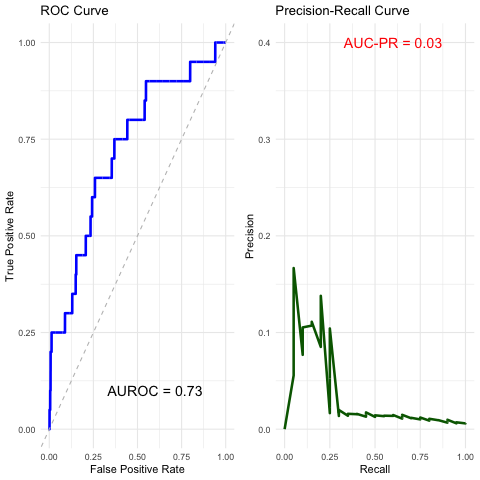

In [19]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)

# Show all plots in a grid (KM comes with table, so best shown separately)
grid.arrange(p1, p2, nrow=1)  # ROC and PR side-by-side

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [20]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]

# Example inputs
percentile_cutoffs = [0, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1]
percentile_high_risk = 0.9 # Chosen percentile for high risk group 

# Assume df_validation_risk exists and has a 'pred_risk' column

# 1. Generate dynamic labels like Q1, Q2, Q3, ...
labels = percentile_cutoffs[1:]

# 2. Assign risk groups based on custom cutoffs
df_validation_risk['risk_group'] = pd.qcut(
    df_validation_risk['pred_risk_cum'],
    q=percentile_cutoffs,
    labels=labels,
    duplicates='drop'  # in case there are tied values
)

# 3. Create dynamic risk indicators
for idx, label in enumerate(labels):
    risk_col = f"risk_p{percentile_cutoffs[idx+1]}"
    include_labels = labels[:idx+1]
    df_validation_risk[risk_col] = np.where(df_validation_risk['risk_group'].isin(include_labels), 0, 1)

# 4. Create low risk and high risk flags
high_risk_idx = percentile_cutoffs.index(percentile_high_risk)
df_validation_risk['high_risk'] = np.where(df_validation_risk['risk_group'] == labels[high_risk_idx], 1, 0)

# 5. Based on optimal Youden threshold
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk['pred_risk_cum'] >= optimal_threshold, 1, 0)


In [21]:
def classification_metrics(risk_group_name, actual_event_name, predicted_class, actual_class):
    # Get confusion matrix: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    total_in_risk_group = predicted_class.sum()
    total_cases_in_risk_group = tp
    prevalance_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1) 

    # Return as dictionary
    return {
        "risk_group": risk_group_name,
        "event": actual_event_name,
        "total pts in risk group": total_in_risk_group,
        "# pts with cancer": f'{total_cases_in_risk_group} ({prevalance_in_risk_group}%)',
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [22]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']

results_by_riskgroup = []

for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(risk_group, event, df_validation_risk[risk_group], df_validation_risk[event])
        results_by_riskgroup.append(row)

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/1835066992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prevalance_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/1835066992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prevalance_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/1835066992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prevalance_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/1835066992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  prevalance_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipy

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [23]:
pd.DataFrame(results_by_riskgroup)

,risk_group,event,total pts in risk group,# pts with cancer,sensitivity,specificity,ppv,npv,youden_index
0,risk_p0.25,ugica_5yr,2509,18 (0.7%),90.000000,25.105232,0.717417,99.761051,0.151052
1,risk_p0.25,escc_5yr,2509,3 (0.1%),100.000000,25.037392,0.119570,100.000000,0.250374
2,risk_p0.25,eac_5yr,2509,3 (0.1%),100.000000,25.037392,0.119570,100.000000,0.250374
3,risk_p0.25,cgc_5yr,2509,4 (0.2%),100.000000,25.044883,0.159426,100.000000,0.250449
4,risk_p0.25,ncgc_5yr,2509,8 (0.3%),80.000000,25.029976,0.318852,99.761051,0.050300
5,risk_p0.5,ugica_5yr,1673,16 (1.0%),80.000000,50.180397,0.956366,99.760909,0.301804
6,risk_p0.5,escc_5yr,1673,2 (0.1%),66.666667,50.014957,0.119546,99.940227,0.166816
7,risk_p0.5,eac_5yr,1673,3 (0.2%),100.000000,50.044870,0.179319,100.000000,0.500449
8,risk_p0.5,cgc_5yr,1673,3 (0.2%),75.000000,50.029922,0.179319,99.940227,0.250299
9,risk_p0.5,ncgc_5yr,1673,8 (0.5%),80.000000,50.089928,0.478183,99.880454,0.300899


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [24]:
pd.DataFrame(results_by_riskgroup).sort_values(by=['event', 'risk_group'])

,risk_group,event,total pts in risk group,# pts with cancer,sensitivity,specificity,ppv,npv,youden_index
3,risk_p0.25,cgc_5yr,2509,4 (0.2%),100.000000,25.044883,0.159426,100.000000,0.250449
8,risk_p0.5,cgc_5yr,1673,3 (0.2%),75.000000,50.029922,0.179319,99.940227,0.250299
13,risk_p0.6,cgc_5yr,1338,3 (0.2%),75.000000,60.053860,0.224215,99.950199,0.350539
18,risk_p0.7,cgc_5yr,1004,3 (0.3%),75.000000,70.047876,0.298805,99.957301,0.450479
23,risk_p0.75,cgc_5yr,837,2 (0.2%),50.000000,75.014961,0.238949,99.920287,0.250150
28,risk_p0.8,cgc_5yr,669,2 (0.3%),50.000000,80.041891,0.298954,99.925290,0.300419
33,risk_p0.85,cgc_5yr,502,2 (0.4%),50.000000,85.038899,0.398406,99.929677,0.350389
38,risk_p0.9,cgc_5yr,335,2 (0.6%),50.000000,90.035907,0.597015,99.933577,0.400359
43,risk_p0.95,cgc_5yr,168,2 (1.2%),50.000000,95.032914,1.190476,99.937067,0.450329
48,risk_p0.975,cgc_5yr,84,2 (2.4%),50.000000,97.546379,2.380952,99.938688,0.475464


### Prevalance of cancer as a function of risk percentile by subtype

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/4114721597.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})


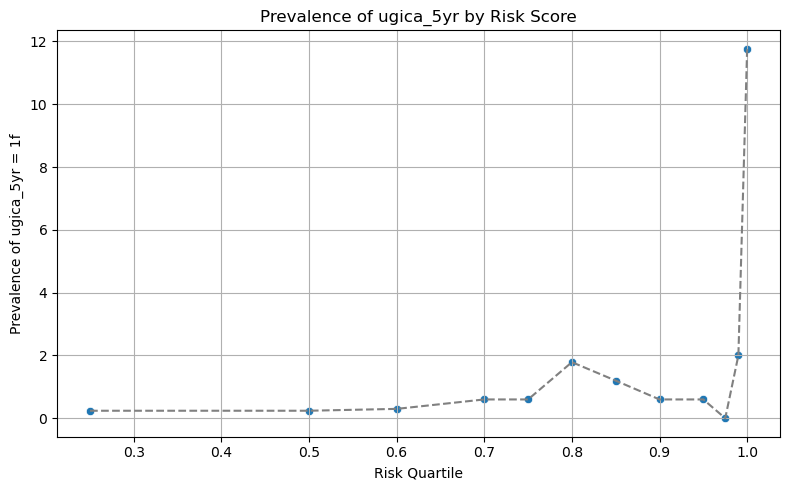

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/4114721597.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})


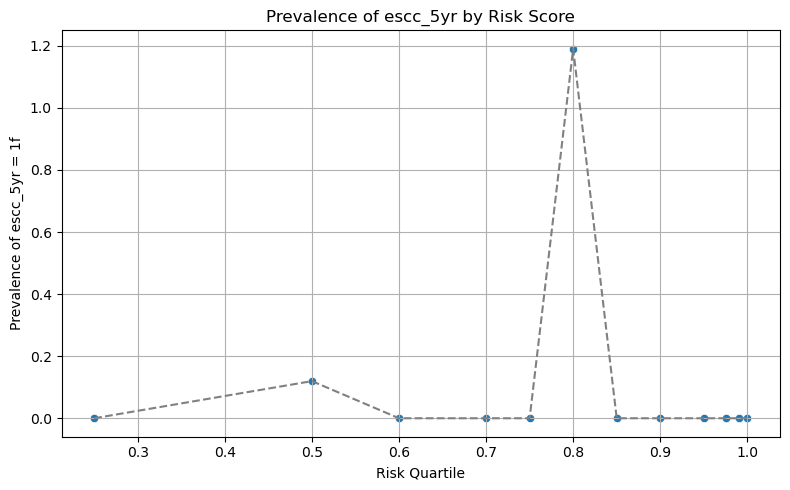

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/4114721597.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})


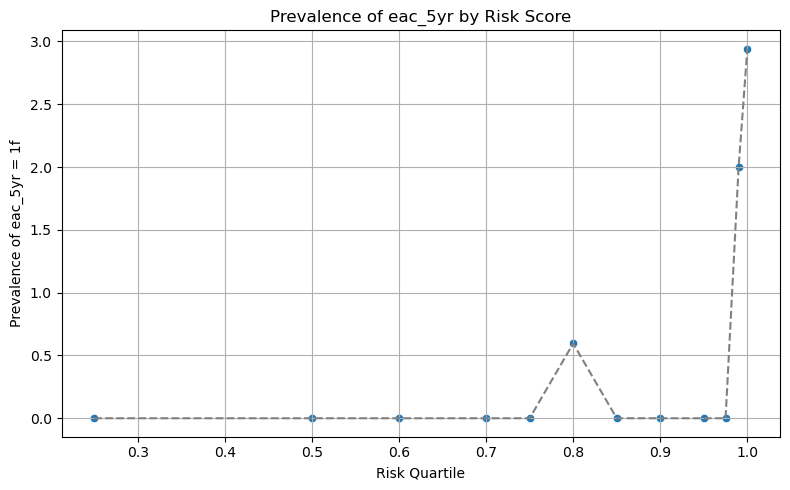

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/4114721597.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})


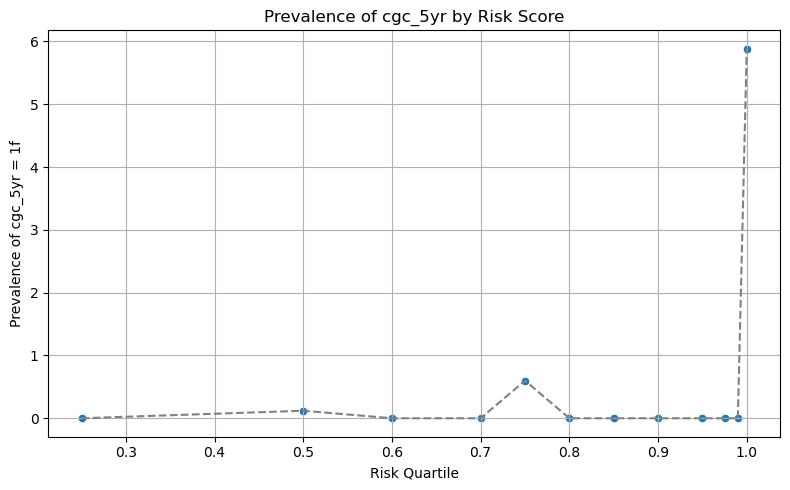

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_39449/4114721597.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})


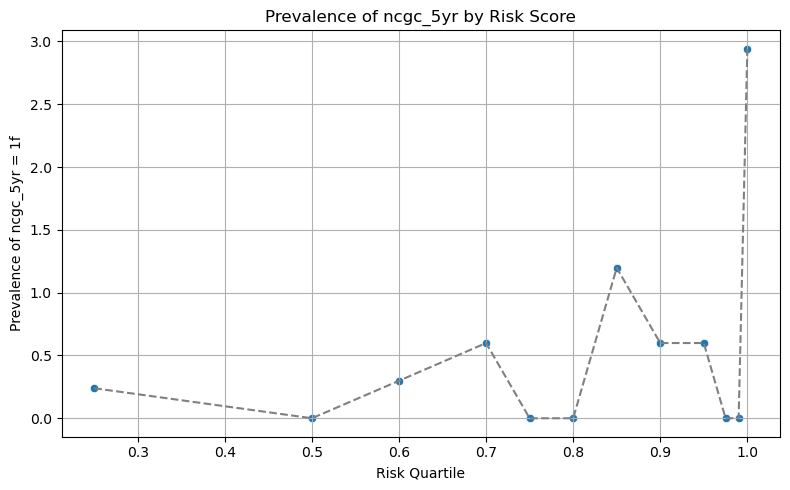

In [25]:
for event in events_5yr:
    # Group by risk_score and calculate prevalence of ugica == 1
    prevalence_df = (df_validation_risk.groupby('risk_group')[event].mean()*100).reset_index().rename(columns = {event: 'prevalence'})

    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=prevalence_df, x='risk_group', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=prevalence_df, x='risk_group', y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Quartile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event} = 1f')
    plt.title(f'Prevalence of {event} by Risk Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Kaplan Meier survival curves stratified by risk group

In [26]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,2465,861
1.0,7,13


In [27]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk)

high_risk,0,1
ugica_5yr,,
0.0,3160,166
1.0,19,1


In [28]:
# Pass dataframe to R to analyze
ro.globalenv['r_df_validation_risk'] = df_validation_risk

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


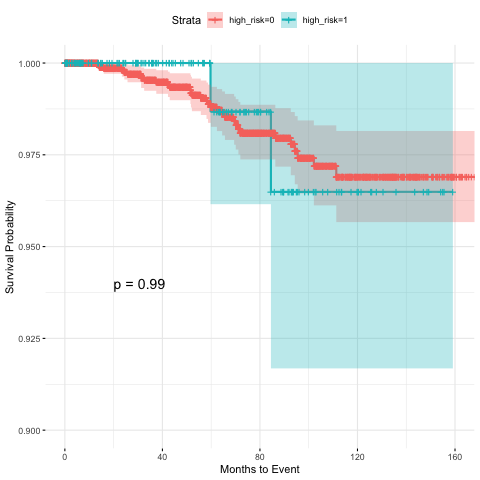

In [29]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot

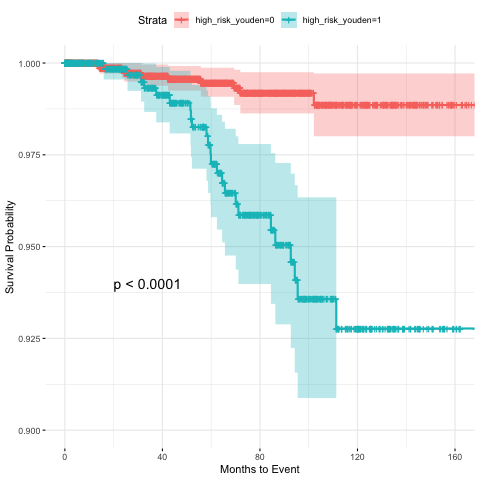

In [30]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot